<a href="https://colab.research.google.com/github/janpeter19/BPL_CHO_Fedbatch/blob/main/BPL_CHO_Fedbatch_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BPL_CHO_Fedbatch script with PyFMI ver 2.7.4

The key library PyFMI v2.7.4 is installed and downgrading is done Numpy v1.19.1. To simplify this we first install conda.

After the installation a small application BPL_CHO_Fedbatch is loaded and run. You can continue with this example if you like.

In [7]:
!lsb_release -a # Actual VM Ubuntu version used by Google

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.6 LTS
Release:	18.04
Codename:	bionic


In [8]:
%env PYTHONPATH=

env: PYTHONPATH=


In [9]:
!wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.12.0-Linux-x86_64.sh 
!chmod +x Miniconda3-py37_4.12.0-Linux-x86_64.sh
!bash ./Miniconda3-py37_4.12.0-Linux-x86_64.sh -b -f -p /usr/local 
import sys 
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2022-08-29 12:20:17--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.12.0-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104996770 (100M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.12.0-Linux-x86_64.sh’

Miniconda3-py37_4.1 100%[===================>] 100.13M   251MB/s    in 0.4s    

2022-08-29 12:20:17 (251 MB/s) - ‘Miniconda3-py37_4.12.0-Linux-x86_64.sh’ saved [104996770/104996770]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ | done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - _openmp_mutex==4.5=1_gnu
    - brotlipy==0.7.0=py37h27cfd23_1003
    - ca-certificates==2022.3.29=h06a4308_1
    - certifi==2021.10.8=py37h06a4308_2
    - cffi==1.15.0=py37hd667e15_1
    

In [10]:
!conda update -n base -c defaults conda --yes

Solving environment: \ | / - \ | / - \ | done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - conda


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _openmp_mutex-5.1          |            1_gnu          21 KB
    ca-certificates-2022.07.19 |       h06a4308_0         124 KB
    certifi-2022.6.15          |   py37h06a4308_0         153 KB
    cffi-1.15.1                |   py37h74dc2b5_0         227 KB
    conda-4.14.0               |   py37h06a4308_0         909 KB
    cryptography-37.0.1        |   py37h9ce1e76_0         1.3 MB
    cytoolz-0.11.0             |   py37h7b6447c_0         328 KB
    ld_impl_linux-64-2.38      |       h1181459_1         654 KB
    libgcc-ng-11.2.0           |       h1234567_1         5.3 MB
    libgomp-11.2.0             |       h1234567_1         474 KB
    libstdcxx-ng-11.2.0        |       h1234

In [11]:
!conda --version
!python --version

conda 4.14.0
Python 3.7.13


In [12]:
!conda install -c conda-forge pyfmi==2.7.4 --yes # Install the key package

Solving environment: - failed with initial frozen solve. Retrying with flexible solve.
Solving environment: / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ 

In [13]:
!conda install numpy=1.19.1 --yes # Need to downgrade numpy

Solving environment: \ failed with initial frozen solve. Retrying with flexible solve.
Solving environment: / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - numpy=1.19.1


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    blas-1.0                   |         openblas          46 KB
    numpy-1.19.1               |   py37h30dfecb_0          21 KB
    numpy-base-1.19.1          |   py37h75fe3a5_0         4.1 MB
    ---------------------------------------------------

# BPL_CHO_Fedbatch demo


Now specific installation and the run simulations. Start with connecting to Github. Then upload the two files:

* FMU - BPL_CHO_Fedbatch_linux_jm_cs.fmu
* Setup-file - BPL_CHO_Fedbatch_explore

In [14]:
# Filter out DepracationWarnings for 'np.float as alias' is needed - wish I could make filter more narrow 
import warnings
warnings.filterwarnings("ignore")

In [15]:
%%bash 
git clone https://github.com/janpeter19/BPL_CHO_Fedbatch

Cloning into 'BPL_CHO_Fedbatch'...


In [16]:
%cd BPL_CHO_Fedbatch

/content/BPL_CHO_Fedbatch/BPL_CHO_Fedbatch


In [17]:
run -i BPL_CHO_Fedbatch_explore.py

Linux - run FMU pre-comiled JModelica 2.4

Model for bioreactor has been setup. Key commands:
 - par()       - change of parameters and initial values
 - init()      - change initial values only
 - simu()      - simulate and plot
 - newplot()   - make a new plot
 - show()      - show plot from previous simulation
 - disp()      - display parameters and initial values from the last simulation
 - describe()  - describe culture, broth, parameters, variables with values / units

Note that both disp() and describe() takes values from the last simulation

Brief information about a command by help(), eg help(simu)
Key system information is listed with the command system_info()


In [18]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [25/2.54, 20/2.54]

In [19]:
describe('culture'); print(); describe('liquidphase')                                  # Pump schedule parameter 


Reactor culture CHO-MAb - cell line HB-58 American Culture Collection ATCC

Reactor broth substances included in the model

Cells viable index =  1 molecular weight =  24.6 Da
Cells dead   index =  2 molecular weight =  24.6 Da
Glucose      index =  3 molecular weight =  180.0 Da
Glutamine    index =  4 molecular weight =  146.1 Da
Lactate      index =  5 molecular weight =  90.1 Da
Ammonia      index =  6 molecular weight =  17.0 Da
Protein      index =  7 molecular weight =  150000.0 Da


Simulation interval    : 0.0 - 200.00000000000003 seconds.
Elapsed simulation time: 0.023053809999510122 seconds.
Simulation interval    : 0.0 - 200.00000000000003 seconds.
Elapsed simulation time: 0.01600876800057449 seconds.


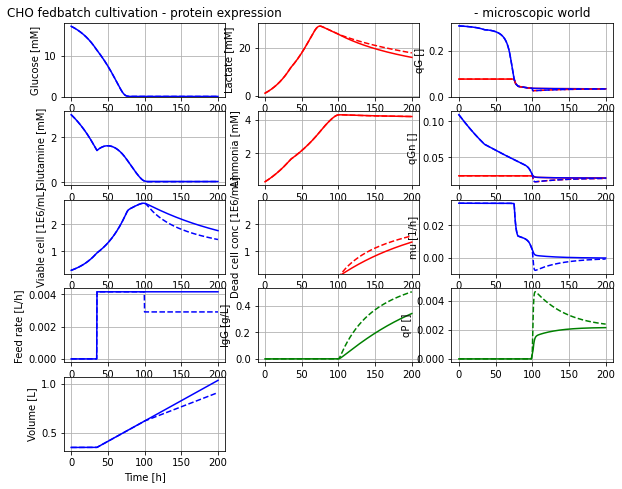

In [20]:
# Slide 3
newplot('CHO fedbatch cultivation - protein expression', plotType='Textbook_3')

# Data from Table 1 and 2 for experiment 3
V_0=0.35
init(V_0=V_0, VXv_0=V_0*0.29, VXd_0=V_0*0.010)
init(VG_0=V_0*17.17, VGn_0=V_0*3.02, VL_0=V_0*1.12, VN_0=V_0*0.29)

# Feeding
Feed=0.1/24
par(G_in=15, Gn_in=9.3)
par(t0=0, F0=0, t1=35, F1=Feed, t2=100, F2=Feed, t3=300, F3=Feed)

# Culture parameters
par(alpha=-1.0, beta=0.01)

# Simulation
simu(200)
par(t2=100, F2=0.7*Feed, t3=300, F3=0.7*Feed); simu(200)
par(F2=Feed, F3=Feed)

In [21]:
disp('culture', decimals=4)

qG_max1 : 0.2971
qG_max2 : 0.0384
qGn_max1 : 0.1238
qGn_max2 : 0.0218
mu_d_max : 0.1302
alpha : -1.0
beta : 0.01


In [22]:
system_info()


System information
 -OS: Linux
 -Python: 3.7.13
 -PyFMI: 2.7.4
 -FMU by: JModelica.org
 -FMI: 2.0
 -Type: FMUModelCS2
 -Name: BPL_CHO.Fedbatch
 -Generated: 2022-08-29T12:13:26
 -MSL: 3.2.2 build 3
 -Description: Bioprocess Library version 2.1.0 beta
 -Interaction: FMU-explore ver 0.9.2
